Importing packages

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import re
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Pobieranie danych z kaggle

In [68]:
train = pd.read_csv("data/pzn-rent-train.csv")
test = pd.read_csv("data/pzn-rent-test.csv")
submit = pd.read_csv("data/pzn-sample-sub.csv")

In [69]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11297 entries, 0 to 11296
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11297 non-null  int64  
 1   ad_title            11297 non-null  object 
 2   date_activ          11297 non-null  object 
 3   date_modif          11297 non-null  object 
 4   date_expire         11297 non-null  object 
 5   individual          10194 non-null  object 
 6   price               11297 non-null  int64  
 7   flat_area           10080 non-null  float64
 8   flat_rooms          10070 non-null  float64
 9   flat_furnished      9980 non-null   object 
 10  flat_rent           11297 non-null  int64  
 11  flat_deposit        11297 non-null  float64
 12  flat_for_students   9493 non-null   object 
 13  building_floor_num  11297 non-null  int64  
 14  flat_balcony        9929 non-null   object 
 15  flat_utility_room   11297 non-null  bool   
 16  flat

In [70]:
print(train.describe(include='all'))

                  id                   ad_title  date_activ  date_modif  \
count   11297.000000                      11297       11297       11297   
unique           NaN                       9114        1216         511   
top              NaN  Mieszkanie, 50 m², Poznań  2020-09-02  2020-09-23   
freq             NaN                         62          51         133   
mean     8210.438878                        NaN         NaN         NaN   
std      4729.098948                        NaN         NaN         NaN   
min         1.000000                        NaN         NaN         NaN   
25%      4115.000000                        NaN         NaN         NaN   
50%      8206.000000                        NaN         NaN         NaN   
75%     12282.000000                        NaN         NaN         NaN   
max     16448.000000                        NaN         NaN         NaN   

       date_expire individual         price     flat_area    flat_rooms  \
count        11297      

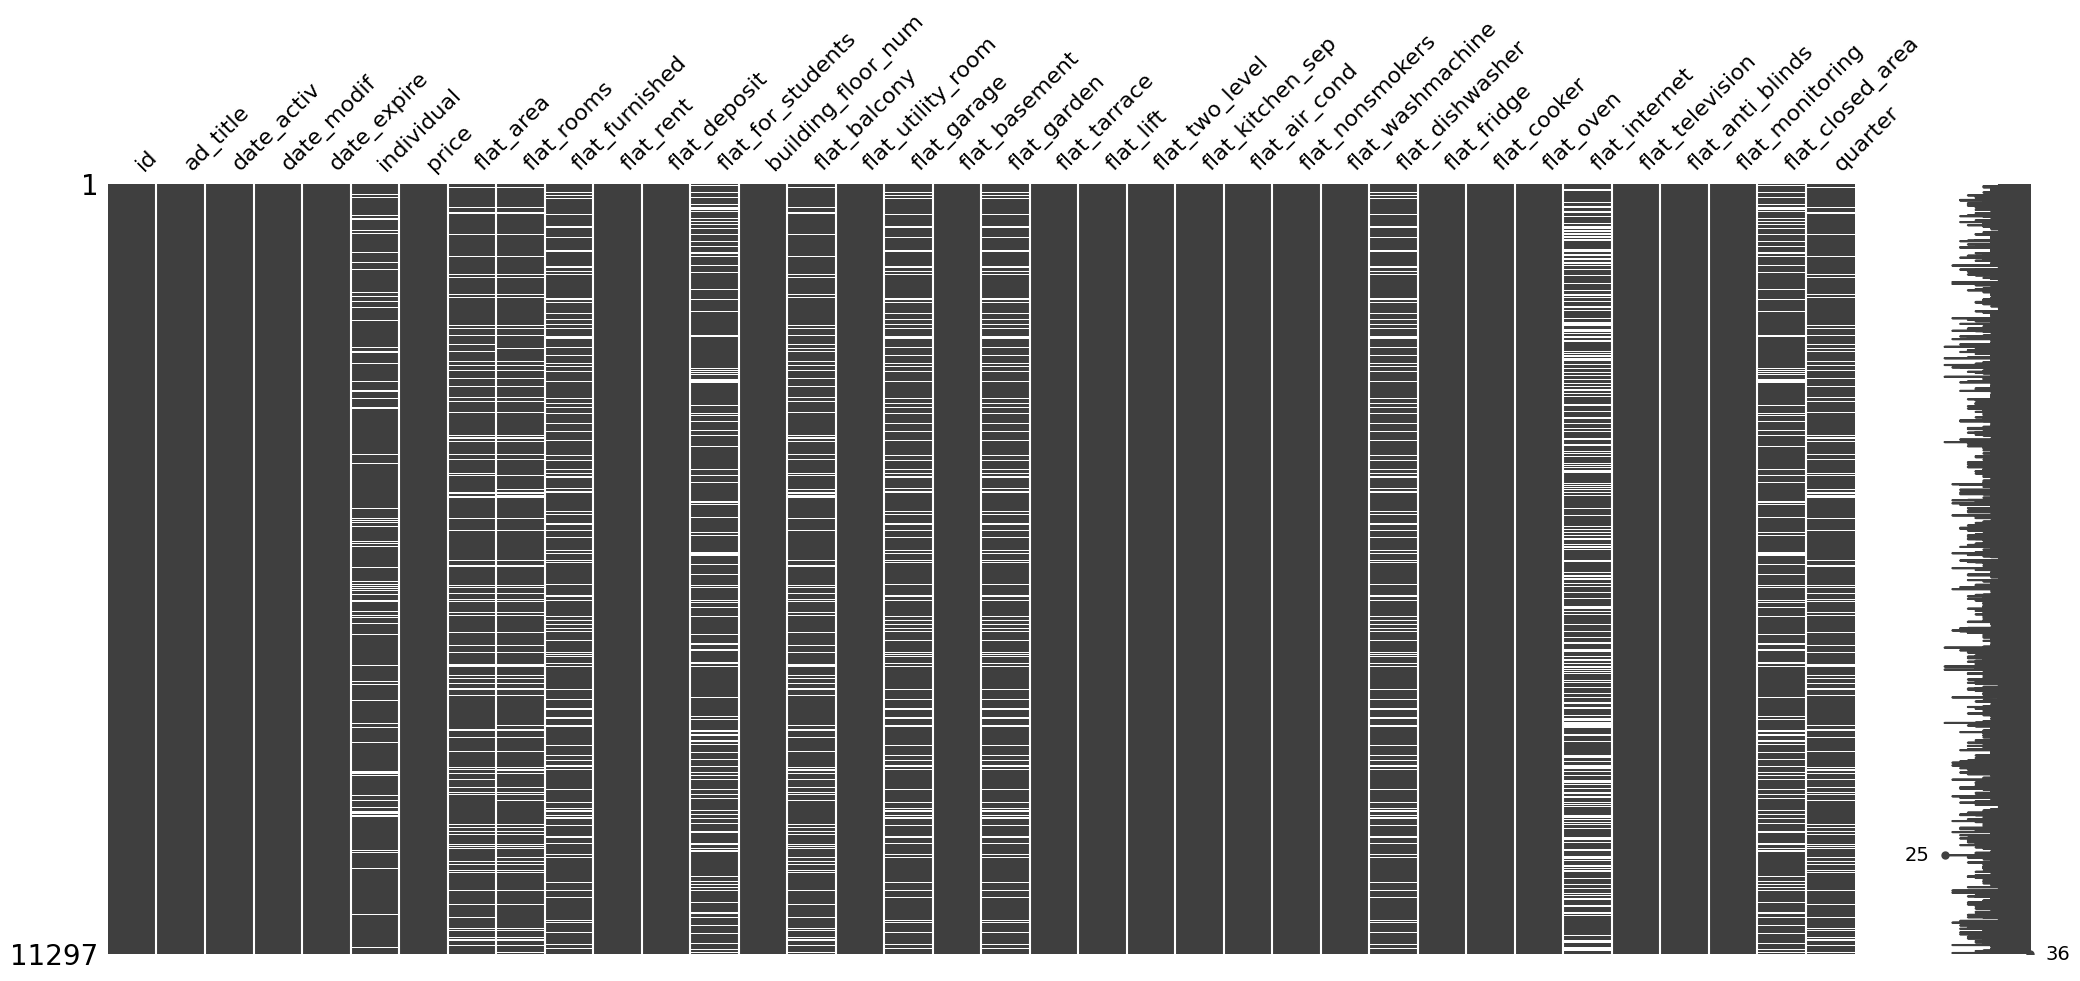

In [71]:
msno.matrix(train)
plt.show()

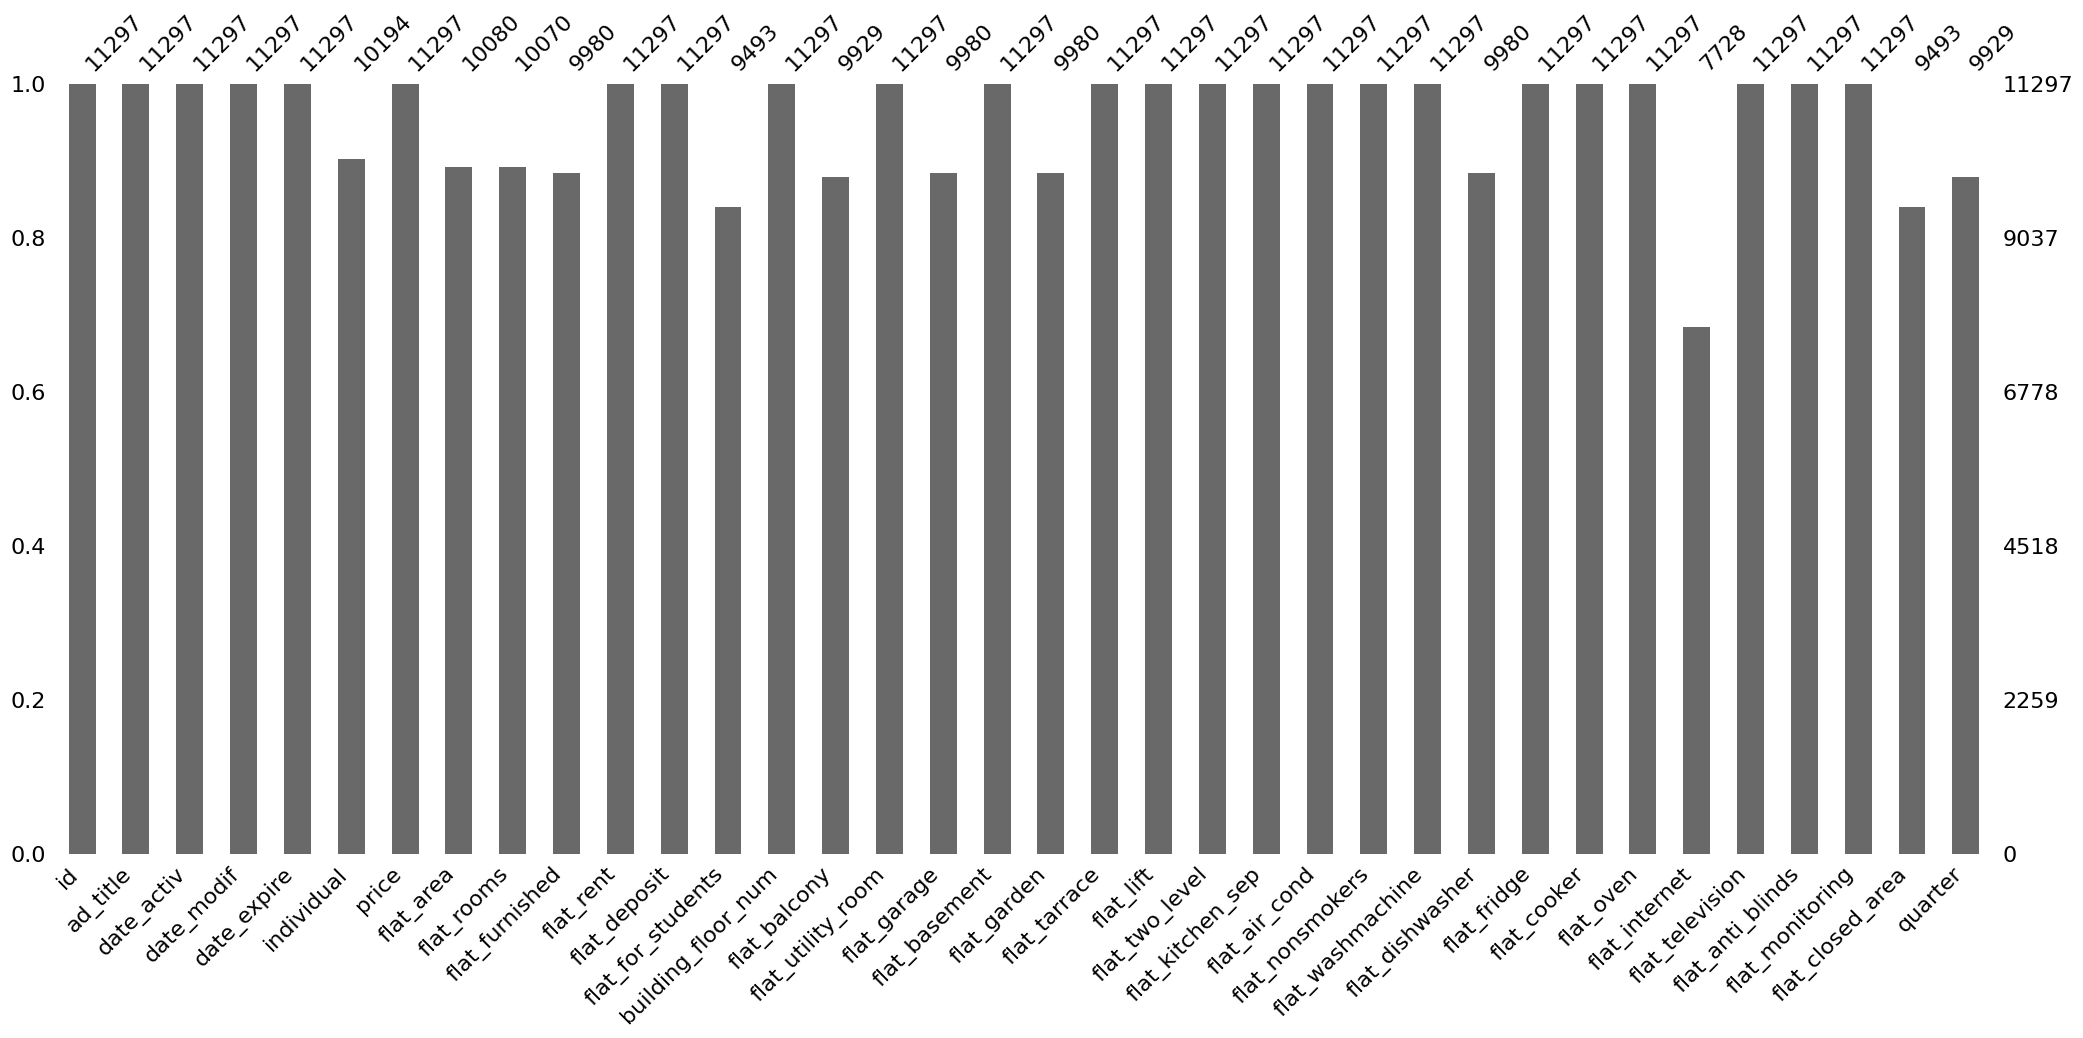

In [72]:
msno.bar(train)
plt.show()

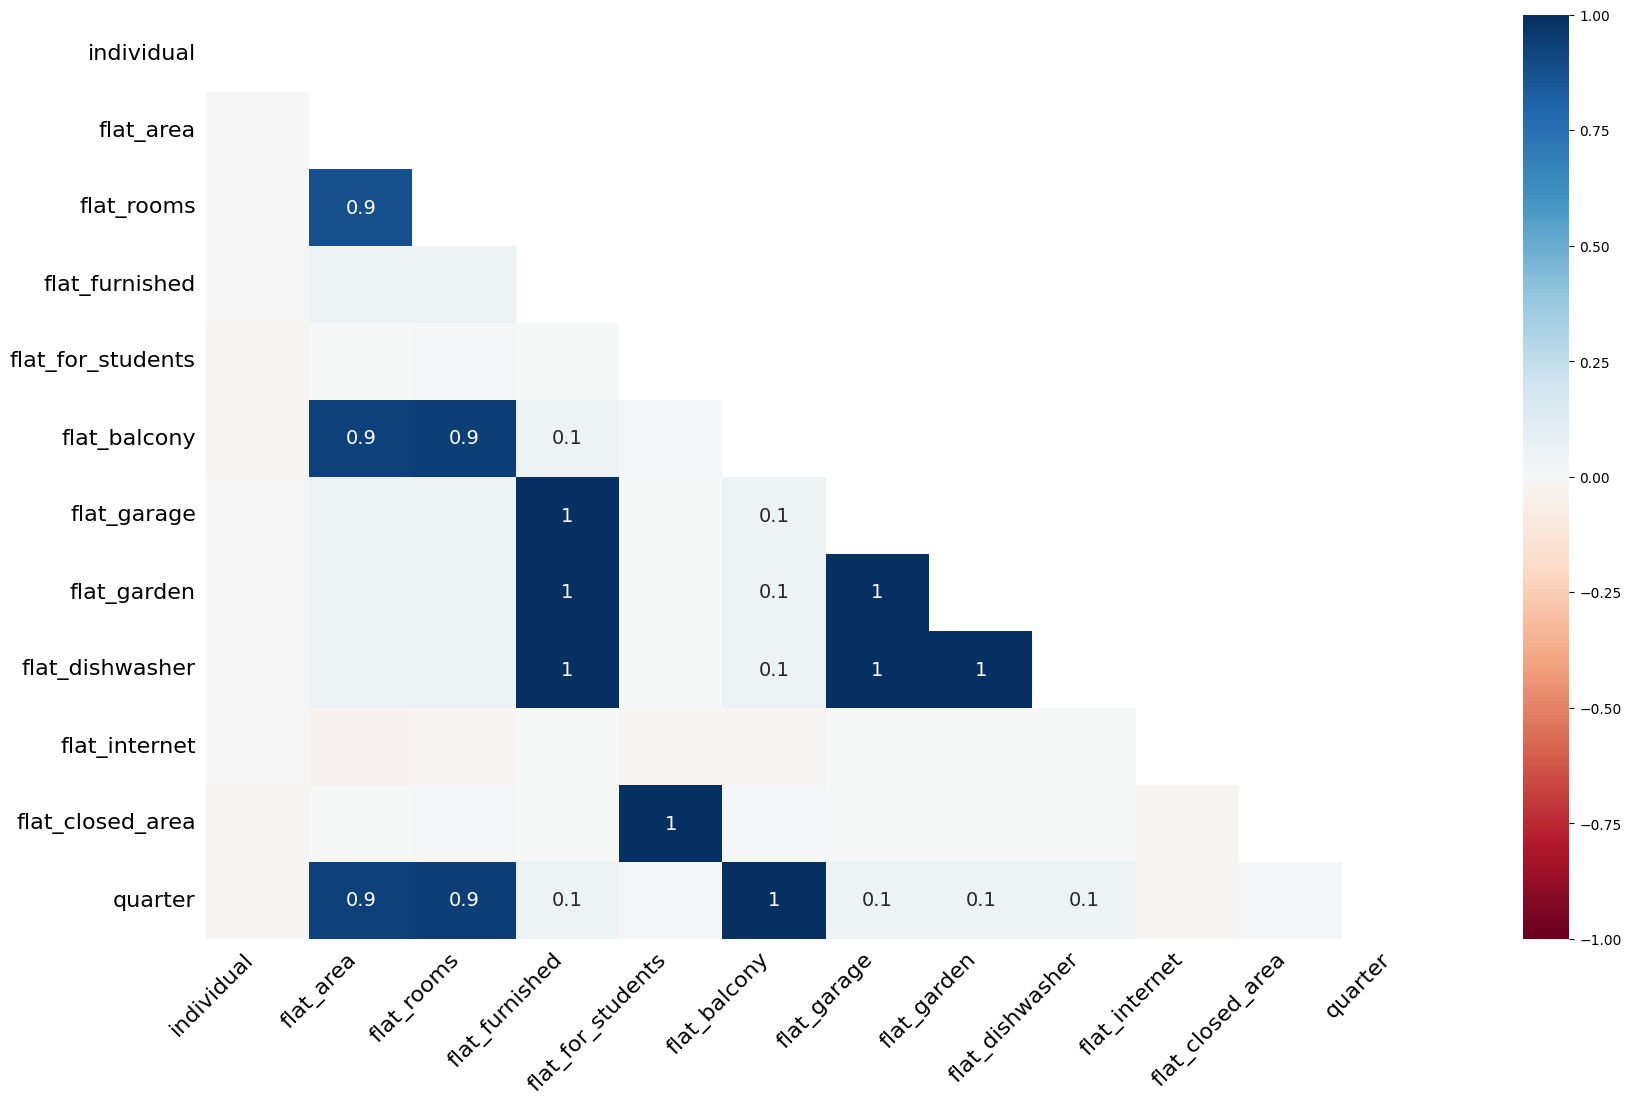

In [73]:
msno.heatmap(train)
plt.show()

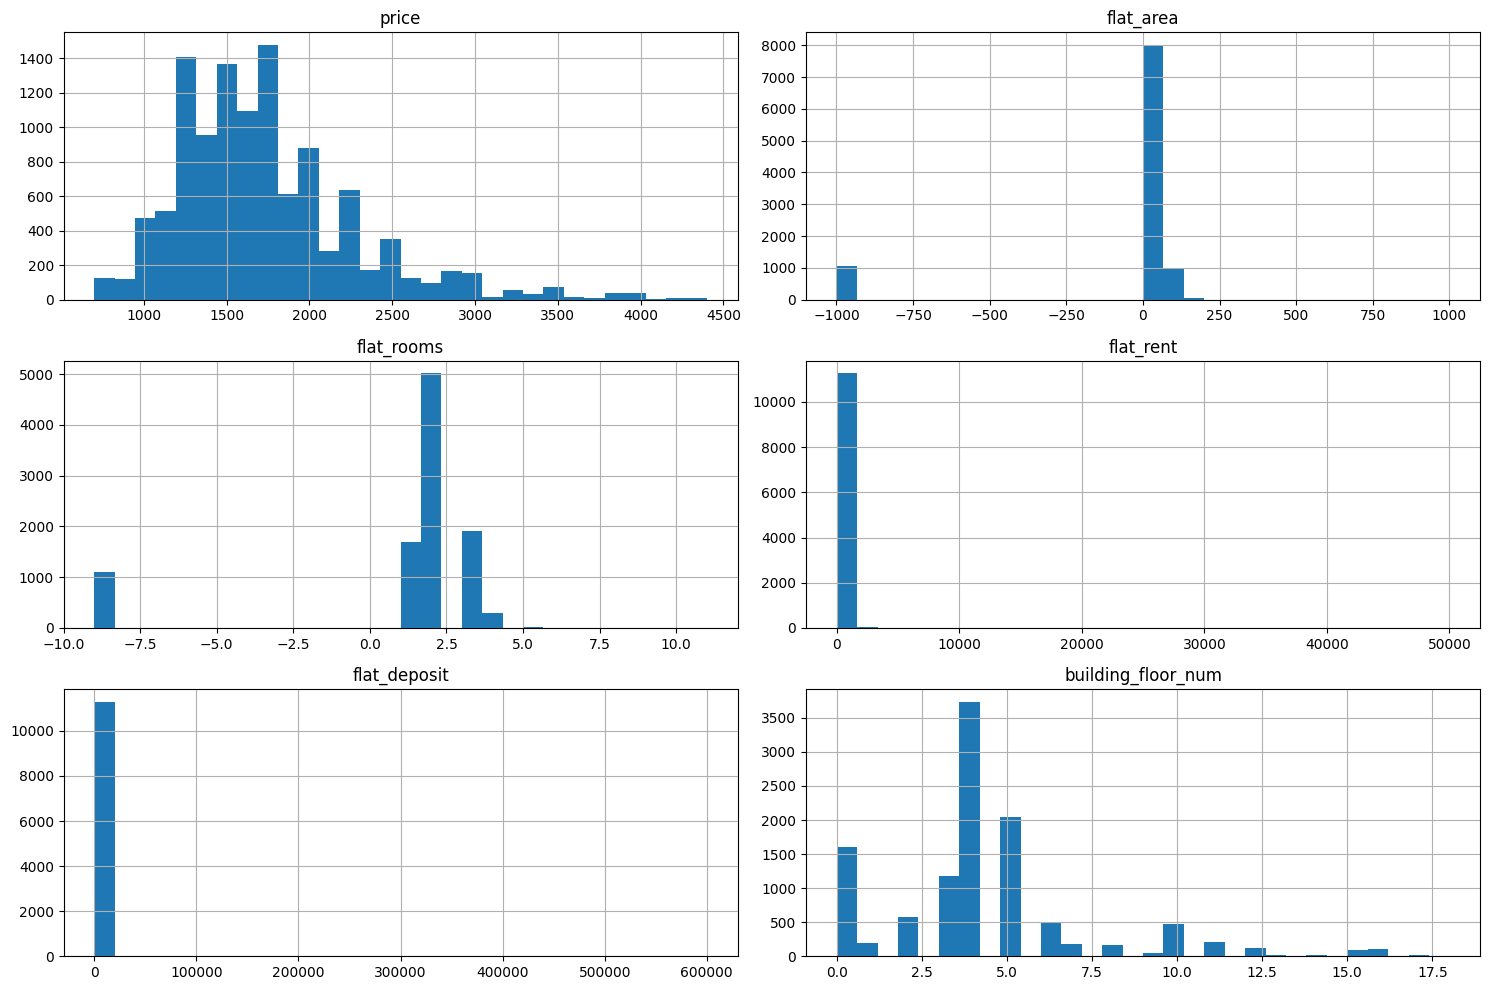

In [74]:
#histogramy dla kolumn numerycznych
train.drop(columns=['id']).hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

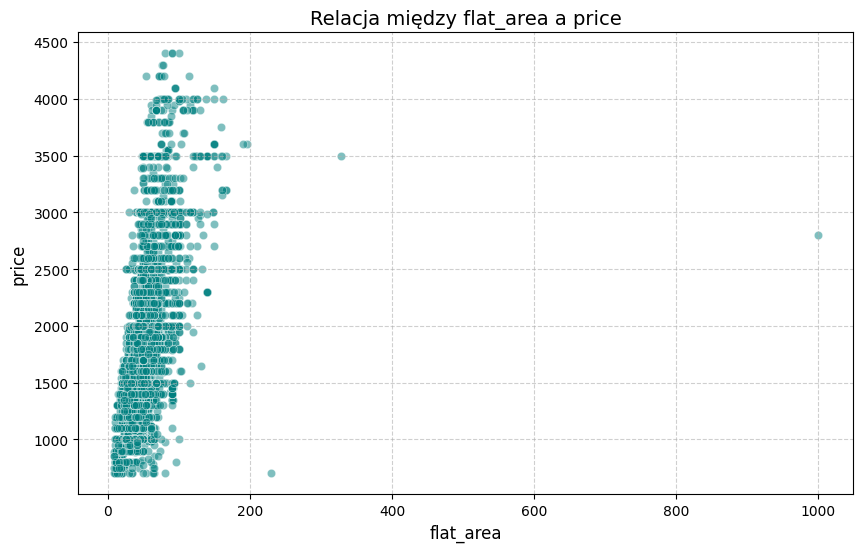

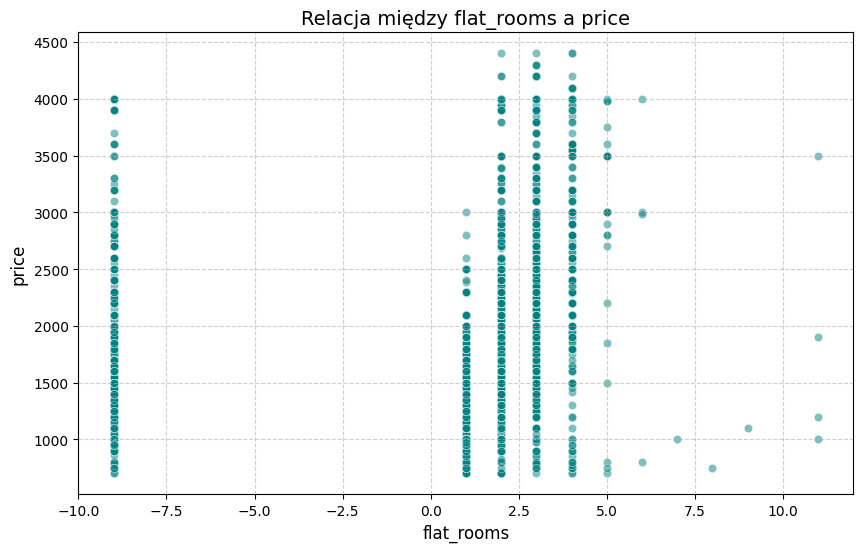

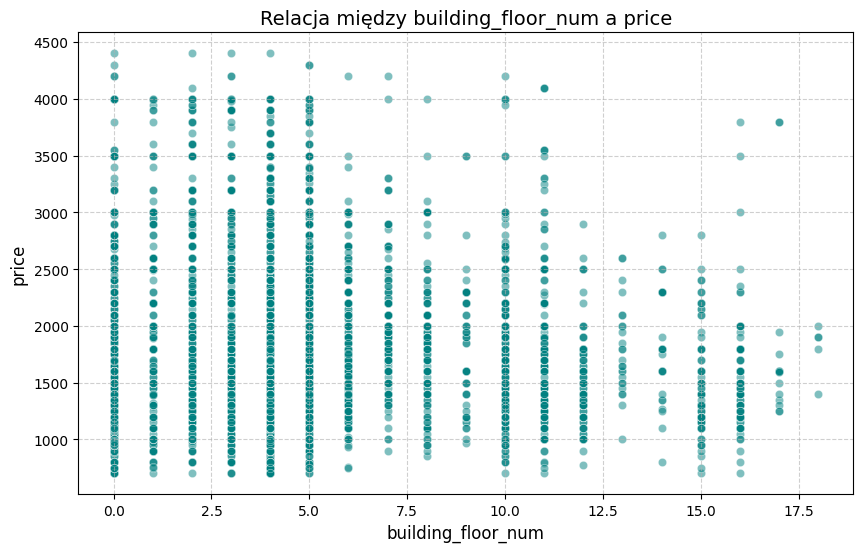

In [75]:
train_clean = train.replace(-999, np.nan)

#zmienne numeryczne 
cols_to_plot = ['flat_area', 'flat_rooms', 'building_floor_num']

for col in cols_to_plot:
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=train_clean, x=col, y='price', alpha=0.5, color='teal')
    
    plt.title(f'Relacja między {col} a price', fontsize=14)
    plt.xlabel(f'{col}', fontsize=12)
    plt.ylabel('price', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

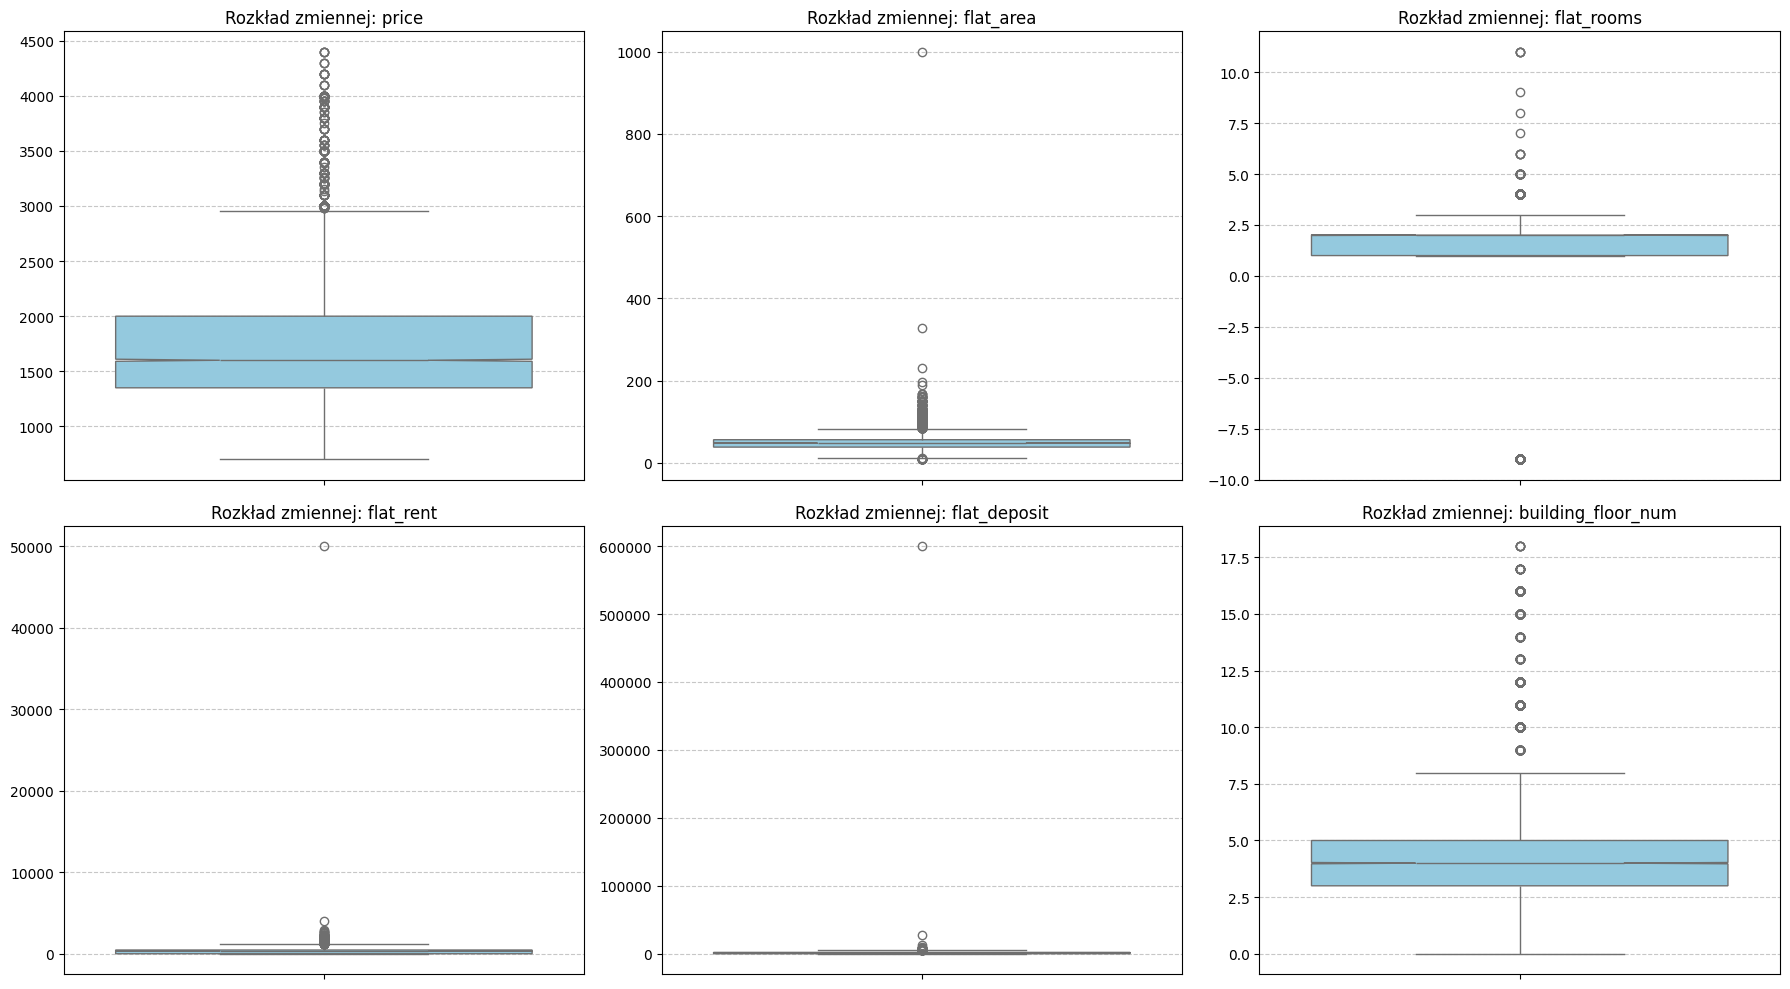

In [76]:
num_cols = ['price', 'flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten() 

for i, col in enumerate(num_cols):
    sns.boxplot(data=train_clean, y=col, ax=axes[i], color='skyblue', notch=True)
    axes[i].set_title(f'Rozkład zmiennej: {col}', fontsize=12)
    axes[i].set_ylabel('') 
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Uzupełnienie danych na podstawie danych z ogłoszenia (REGEX)

In [77]:
def extract_area_from_title(title):
    if pd.isna(title):
        return np.nan
    
    # Wzorce "10 m2", "10.5 m2", "10,5 mkw", "10metrów"
    match = re.search(r'(\d+[.,]?\d*)\s*(m2|mkw|metr|m²|sqm)', str(title), re.IGNORECASE)
    
    if match:
        res = match.group(1).replace(',', '.') 
        try:
            return float(res)
        except:
            return np.nan
    return np.nan

train['flat_area'] = train['flat_area'].replace(-999, np.nan)

extracted_areas = train['ad_title'].apply(extract_area_from_title)

missing_before = train['flat_area'].isna().sum()
can_fix = (train['flat_area'].isna() & extracted_areas.notna()).sum()

train['flat_area'] = train['flat_area'].fillna(extracted_areas)

print(f"Liczba braków przed: {missing_before}")
print(f"Liczba uzupełnionych: {can_fix}")
print(f"Liczba braków po operacji: {train['flat_area'].isna().sum()}")


print(train['flat_area'].describe())

Liczba braków przed: 2286
Liczba uzupełnionych: 400
Liczba braków po operacji: 1886
count    9411.000000
mean       48.940694
std        20.589958
min         7.000000
25%        38.000000
50%        47.000000
75%        56.000000
max      1000.000000
Name: flat_area, dtype: float64


In [78]:
missing_flat_area = train[train['flat_area'].isna()]

print(missing_flat_area[['ad_title', 'flat_area']].head(30))

                                              ad_title  flat_area
40   OKAZJA - 2 niezależne pokoje w CENTRUM, St. Br...        NaN
48     Kawalerka w dobrym stanie,od zaraz/Blisko Ronda        NaN
51      Kawalerka w zrewitalizowanej kamienicy z windą        NaN
56    Bezpośrednio kawalerka najem Poznań Stare Miasto        NaN
58        Św. Marcin, 3 pomieszczenia z windą na BIURO        NaN
64                                  Strzeszyn 4 pokoje        NaN
72                   Kawalerka Poznań Osiedle Lecha 16        NaN
90                       Kawalerka do wynajęcia Dębiec        NaN
92           2-pokojowe mieszkanie w super lokalizacji        NaN
97   Kawalerka przy Starym Rynku - 1000zł + tylko l...        NaN
99                  Mieszkanie 3 pokojowe! ul. Błażeja        NaN
100  Mieszkanie 2 pokoje Poznań Chrobrego Piątkowo ...        NaN
104                 Ładna kawalerka. Grunwald. OKAZJA!        NaN
113  Klimatyczna Kawalerka w Centrum od 1 pazdziernika        NaN
124       

In [79]:
def extract_rooms_from_title(title):
    if pd.isna(title):
        return np.nan
    title_str = str(title).lower()
    
    # 1 pokój ==
    if 'kawalerka' in title_str or 'studio' in title_str or 'kawalerki' in title_str or 'kawalerkę' in title_str:
        return 1.0
    
    # 1 przed pokojem
    match = re.search(r'(\d+)\s*(?:[a-ząćęłńóśźż]+\s+)?-?pok', title_str)
    if match:
        return float(match.group(1))
    
    return np.nan

train['flat_rooms'] = train['flat_rooms'].replace(-9, np.nan)
extracted_rooms = train['ad_title'].apply(extract_rooms_from_title)

can_fix_rooms = (train['flat_rooms'].isna() & extracted_rooms.notna()).sum()
train['flat_rooms'] = train['flat_rooms'].fillna(extracted_rooms)

print(f"Uzupełniono flat_rooms: {can_fix_rooms}")
print(f"Liczba braków po operacji: {train['flat_rooms'].isna().sum()}")

Uzupełniono flat_rooms: 1531
Liczba braków po operacji: 807


In [80]:
missing_flat_rooms = train[train['flat_rooms'].isna()]

print(missing_flat_rooms[['ad_title', 'flat_rooms']].head(30))

                                              ad_title  flat_rooms
18       Poznań Malta- mieszkanie do wynajęcia + garaż         NaN
86                                   Pokoje Na Wynajem         NaN
128                        Piękne mieszkanie w centrum         NaN
143  Winogrady, Wilczak umeblowane, z widokiem na W...         NaN
162                        Nowe mieszkanie na Jeżycach         NaN
179   Nowoczesne, świeżo wykończone, parking + komórka         NaN
180    Poznań Przybyszewskiego, doskonała lokalizacja.         NaN
209                Grunwald Uniwersytet Medyczny Garaż         NaN
217                    Ładne Mieszkanie Na Strzeszynie         NaN
227                          Mieszkanie, 60 m², Poznań         NaN
228                          Mieszkanie, 46 m², Poznań         NaN
234                          Mieszkanie, 20 m², Poznań         NaN
252             Mieszkanie z balkonem ul. Dominikańska         NaN
256             Nowoczesne mieszkanie w nowym obiekcie        

Podmianka dzielnicy z tytułu - do przegadania

In [81]:
known_quarters = sorted(train['quarter'].dropna().unique().tolist(), key=len, reverse=True)

def check_quarter_consistency(row):
    title = str(row['ad_title']).lower()
    current_q = str(row['quarter']).lower() if pd.notna(row['quarter']) else None
    
    # Szukamy czy jakakolwiek znana dzielnica występuje w tytule
    found_in_title = None
    for q in known_quarters:
        if q.lower() in title:
            found_in_title = q
            break # bierzemy pierwszą pasującą (najdłuższą)
            
    # Logika porównania
    if current_q is None:
        if found_in_title:
            return f"MOŻNA UZUPEŁNIĆ: {found_in_title}"
        return "BRAK DANYCH (w obu)"
    
    if current_q in title:
        return "ZGODNE"
    
    if found_in_title and found_in_title.lower() != current_q:
        return f"KONFLIKT? Tytuł sugeruje: {found_in_title}"
    
    return "W tytule brak nazwy dzielnicy"

# Zastosowanie funkcji
train['quarter_check'] = train.apply(check_quarter_consistency, axis=1)

# Wyświetlenie statystyk
print("--- Statystyki zgodności dzielnic ---")
print(train['quarter_check'].value_counts())

# Wyświetlenie 10 przykładów, gdzie można uzupełnić dane
print("\n--- Przykłady do uzupełnienia (NaN w quarter -> nazwa w tytule) ---")
print(train[train['quarter_check'].str.contains("MOŻNA UZUPEŁNIĆ")][['ad_title', 'quarter', 'quarter_check']].head(10))

--- Statystyki zgodności dzielnic ---
quarter_check
W tytule brak nazwy dzielnicy         6105
ZGODNE                                2752
BRAK DANYCH (w obu)                    799
KONFLIKT? Tytuł sugeruje: Centrum      556
MOŻNA UZUPEŁNIĆ: Centrum               196
                                      ... 
MOŻNA UZUPEŁNIĆ: Rynek Łazarski          1
KONFLIKT? Tytuł sugeruje: Piotrowo       1
MOŻNA UZUPEŁNIĆ: Chartowo                1
MOŻNA UZUPEŁNIĆ: Warszawskie             1
MOŻNA UZUPEŁNIĆ: Szeląg                  1
Name: count, Length: 87, dtype: int64

--- Przykłady do uzupełnienia (NaN w quarter -> nazwa w tytule) ---
                                              ad_title quarter  \
56    Bezpośrednio kawalerka najem Poznań Stare Miasto     NaN   
71    kawalerka 32m2, super lokalizacja ścisłe centrum     NaN   
90                       Kawalerka do wynajęcia Dębiec     NaN   
100  Mieszkanie 2 pokoje Poznań Chrobrego Piątkowo ...     NaN   
104                 Ładna kawalerka. G

Funkcja do sprawdzania dokładności metod imputacji i ich ewaluacji

In [82]:
def evaluate_imputation_methods(df, target_col, predictor_cols):
    data_complete = df.dropna(subset=[target_col] + predictor_cols).copy()
    
    X = data_complete[predictor_cols]
    y = data_complete[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = {}

    #Średnia globalna
    y_pred_mean = np.full_like(y_test, y_train.mean())
    results['Średnia'] = np.sqrt(mean_squared_error(y_test, y_pred_mean))

    #Mediana globalna
    y_pred_med = np.full_like(y_test, y_train.median())
    results['Mediana'] = np.sqrt(mean_squared_error(y_test, y_pred_med))

    #Regresja Liniowa 
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    results['Regresja'] = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    #KNN 
    knn = KNNImputer(n_neighbors=5)
    
    test_hidden = X_test.copy()
    test_hidden[target_col] = np.nan
    train_full = pd.concat([X_train, y_train], axis=1)
    
    
    imputed_data = knn.fit(train_full).transform(pd.concat([test_hidden, y_test.to_frame()], axis=0))
    y_pred_knn = imputed_data[:len(y_test), -1]
    results['KNN (k=5)'] = np.sqrt(mean_squared_error(y_test, y_pred_knn))

    return results


area_eval = evaluate_imputation_methods(train, 'flat_area', ['flat_rooms', 'price'])
print("Błędy dla flat_area:", area_eval)


rooms_eval = evaluate_imputation_methods(train, 'flat_rooms', ['flat_area', 'price'])
print("Błędy dla flat_rooms:", rooms_eval)

Błędy dla flat_area: {'Średnia': np.float64(28.864747715988965), 'Mediana': np.float64(28.978599916939867), 'Regresja': np.float64(24.13057792170773), 'KNN (k=5)': np.float64(24.620442942099327)}
Błędy dla flat_rooms: {'Średnia': np.float64(0.8172645291475483), 'Mediana': np.float64(0.8238031836508393), 'Regresja': np.float64(0.7983716029081758), 'KNN (k=5)': np.float64(0.5602567629662655)}


In [83]:
test.replace(-999, np.nan, inplace=True)
num_cols_test = test.select_dtypes(include=[np.number]).columns
for col in num_cols_test:
    test.loc[test[col] < 0, col] = np.nan

extracted_area_test = test['ad_title'].apply(extract_area_from_title)
test['flat_area'] = test['flat_area'].fillna(extracted_area_test)


extracted_rooms_test = test['ad_title'].apply(extract_rooms_from_title)
test['flat_rooms'] = test['flat_rooms'].fillna(extracted_rooms_test)

print("Brakujące wartości w zbiorze test")
print(test[['flat_area', 'flat_rooms']].isna().sum())

Brakujące wartości w zbiorze test
flat_area     800
flat_rooms    354
dtype: int64


In [84]:
for df in [train, test]:
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df.loc[df[col] < 0, col] = np.nan
    
    df['flat_area'] = df['flat_area'].fillna(df['ad_title'].apply(extract_area_from_title))
    df['flat_rooms'] = df['flat_rooms'].fillna(df['ad_title'].apply(extract_rooms_from_title))


In [85]:
impute_features = ['flat_area', 'flat_rooms', 'flat_rent', 'building_floor_num']

imputer = KNNImputer(n_neighbors=5)

imputer.fit(train[impute_features])

train[impute_features] = imputer.transform(train[impute_features])

test[impute_features] = imputer.transform(test[impute_features])

train['flat_rooms'] = train['flat_rooms'].round()
test['flat_rooms'] = test['flat_rooms'].round()

print("Braki")
print(f"Train flat_area: {train['flat_area'].isna().sum()}")
print(f"Test flat_area: {test['flat_area'].isna().sum()}")

Braki
Train flat_area: 0
Test flat_area: 0


In [86]:
print(train[['flat_area', 'flat_rooms']].describe())

          flat_area    flat_rooms
count  11297.000000  11297.000000
mean      47.690194      1.979906
std       19.531635      0.793165
min        7.000000      1.000000
25%       37.000000      1.000000
50%       46.000000      2.000000
75%       54.434000      2.000000
max     1000.000000     11.000000


In [87]:
print(train[['flat_area', 'flat_rooms']].head())

   flat_area  flat_rooms
0       49.0         2.0
1       65.0         3.0
2       30.0         1.0
3       10.0         1.0
4       47.0         2.0
